In [2]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [3]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager


from examples.fracture import configs
from examples.fracture.model import PINN

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})



In [48]:
cfg = configs.Config()
pinn = PINN(config=cfg)
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/fracture/irr/2025-04-17-20-50-41/model-4500/")
params = state["params"]

In [49]:
ts = jnp.linspace(0, 1, 101)
# mesh = jnp.load(f"{cfg.DATA_PATH}/mesh_points.npy") / cfg.Lc
xs = jnp.linspace(-0.5, 0.5, 1000)
ys = jnp.ones_like(xs) * 0.5
top_mesh = jnp.stack([xs, ys], axis=1)

tractions = []
for idx, tic in enumerate(ts):
    t = jnp.ones_like(top_mesh[:, 0]) * tic
    t = t.reshape(-1, 1)
    # phi, disp = vmap(
    #     pinn.net_u, in_axes=(None, 0, 0)
    # )(params, top_mesh, t)

    sigma = vmap(
        pinn.sigma, in_axes=(None, 0, 0)
    )(params, top_mesh, t)
    sigma_yy = sigma[:, -1, -1]
    traction_yy = jnp.sum(
        (sigma_yy[:-1] + sigma_yy[1:]) / 2 * (xs[1:] - xs[:-1])
    )
    tractions.append(traction_yy)
tractions = jnp.array(tractions)

[Text(0.5, 0, 'Displacement (mm)'), Text(0, 0.5, 'Traction (N/mm)')]

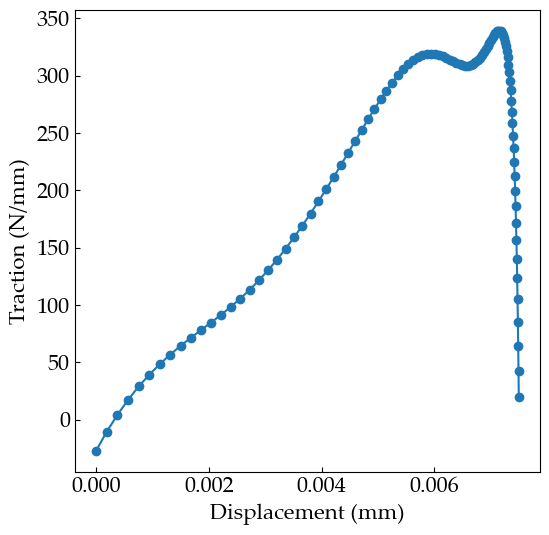

In [50]:
%matplotlib inline

loading = cfg.loading(ts)
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(loading, tractions, label="traction", marker="o",)
ax.set(
    xlabel="Displacement (mm)",
    ylabel="Traction (N/mm)",
)


[Text(0.5, 0, 'y'),
 Text(0, 0.5, 'displacement'),
 Text(0.5, 1.0, 'Displacement at x=0.0, loading=0.0075')]

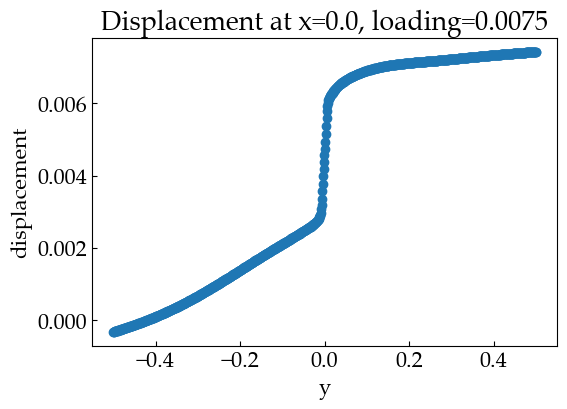

In [52]:
ys = jnp.linspace(-0.5, 0.5, 1000)
xs = jnp.ones_like(ys) * (-0.25)
slice_mesh = jnp.stack([xs, ys], axis=1)
tic = 1.0
t = jnp.ones_like(slice_mesh[:, 0]) * tic
t = t.reshape(-1, 1)
phi, disp = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, slice_mesh, t)
disp_loading = cfg.loading(tic)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ys, disp[:, 1], label="displacement", marker="o",)
ax.set(
    xlabel="y",
    ylabel="displacement",
    title=f"Displacement at x=0.0, loading={disp_loading:.4f}",
)

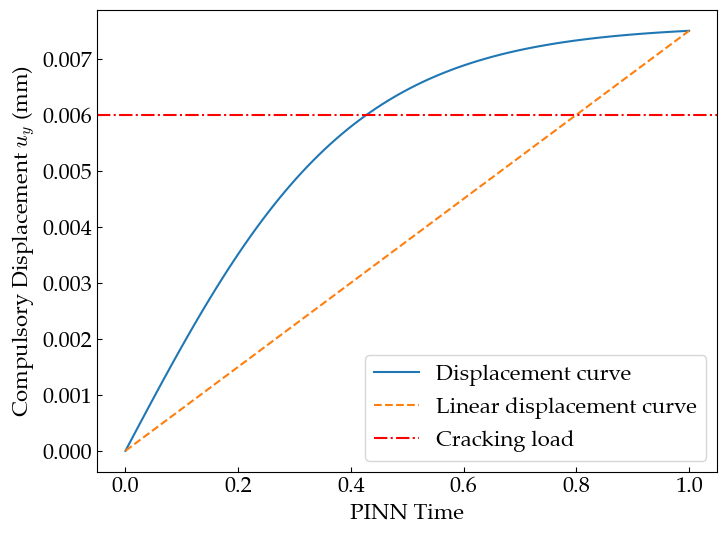

In [23]:
%matplotlib inline

t = jnp.linspace(0, 1, 100)
load = cfg.loading(t)
load_linear = t * 0.0075
cracking_load = 0.006

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t, load, label="Displacement curve",)
ax.plot(t, load_linear, label="Linear displacement curve", linestyle="--")
ax.axhline(cracking_load, color="red", linestyle="-.", label="Cracking load")
ax.set(xlabel="PINN Time", ylabel="Compulsory Displacement $u_y$ (mm)")
ax.legend()

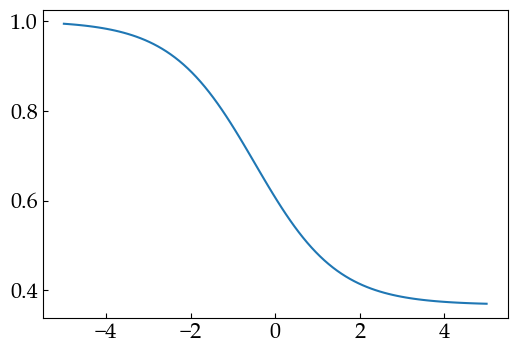

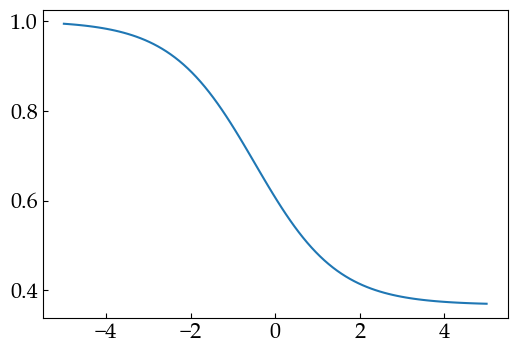

In [5]:
%matplotlib inline
x = jnp.linspace(-5, 5, 100)
y = jnp.exp(-jax.nn.sigmoid(x))
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, label="sigmoid")